In [0]:
import time
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
# Constants
RANDOM_SEED = 1
BATCH_SIZE = 100
NUM_EPOCHS = 50
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# MNIST Dataset
train_dataset = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor())

# Batches with DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


In [3]:
# Understanding dataset
print(len(train_dataset))
print(len(test_dataset))

for images, labels in train_loader:
  print(images.shape)
  print(labels.shape)
  break

60000
10000
torch.Size([100, 1, 28, 28])
torch.Size([100])


In [0]:
# Model definition
class MlpMnist(torch.nn.Module):
  
  def __init__(self, num_features, num_hidden, num_classes):
    super(MlpMnist, self).__init__()

    self.num_classes = num_classes

    # Layer 1 (hidden)
    self.linear_1 = torch.nn.Linear(num_features, num_hidden)
    self.linear_1.weight.detach().normal_(0.0, 0.1)
    self.linear_1.bias.detach().zero_()

    # Layer 2 (output)
    self.linear_out = torch.nn.Linear(num_hidden, num_classes)
    self.linear_out.weight.detach().normal_(0.0, 0.1)
    self.linear_out.bias.detach().zero_()

  def forward(self, x):
    z1 = self.linear_1(x)
    a1 = torch.sigmoid(z1)
    z2 = self.linear_out(a1)
    a2 = torch.softmax(z2, dim=1)
    return z2, a2

In [0]:
# Model initialization
torch.manual_seed(RANDOM_SEED)
model = MlpMnist(num_features=28*28, num_hidden=100, num_classes=10)

model = model.to(DEVICE)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

In [0]:
# Compute loss using cross entropy
def compute_loss(model, data_loader):
  curr_loss = 0
  with torch.no_grad():
    for count, (features, targets) in enumerate(data_loader):
      features = features.view(-1, 28*28).to(DEVICE)
      targets = targets.to(DEVICE)
      logits, probas = model.forward(features)
      loss = F.cross_entropy(logits, targets)
      curr_loss += loss
    return float(curr_loss)/count

In [7]:
# Model training
start_time = time.time()
epoch_cost = []

for epoch in range(NUM_EPOCHS):
  model.train()

  for batch_id, (features, targets) in enumerate(train_loader):

    # set inputs and labels
    features = features.view(-1, 28*28).to(DEVICE)
    targets = targets.to(DEVICE)

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward
    logits, probas = model(features)
    cost = F.cross_entropy(logits, targets)
    cost.backward()

    # update parameters
    optimizer.step()

  cost = compute_loss(model, train_loader)
  epoch_cost.append(cost)
  print('Epoch: %02d/%02d Train cost: %.4f' % (epoch + 1, NUM_EPOCHS, cost))
  print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

print('Total training time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 01/50 Train cost: 0.4951
Time elapsed: 0.30 min
Epoch: 02/50 Train cost: 0.3739
Time elapsed: 0.61 min
Epoch: 03/50 Train cost: 0.3302
Time elapsed: 0.92 min
Epoch: 04/50 Train cost: 0.3037
Time elapsed: 1.22 min
Epoch: 05/50 Train cost: 0.2860
Time elapsed: 1.53 min
Epoch: 06/50 Train cost: 0.2703
Time elapsed: 1.84 min
Epoch: 07/50 Train cost: 0.2570
Time elapsed: 2.14 min
Epoch: 08/50 Train cost: 0.2453
Time elapsed: 2.46 min
Epoch: 09/50 Train cost: 0.2346
Time elapsed: 2.77 min
Epoch: 10/50 Train cost: 0.2255
Time elapsed: 3.07 min
Epoch: 11/50 Train cost: 0.2162
Time elapsed: 3.39 min
Epoch: 12/50 Train cost: 0.2090
Time elapsed: 3.70 min
Epoch: 13/50 Train cost: 0.2009
Time elapsed: 4.01 min
Epoch: 14/50 Train cost: 0.1942
Time elapsed: 4.32 min
Epoch: 15/50 Train cost: 0.1872
Time elapsed: 4.63 min
Epoch: 16/50 Train cost: 0.1837
Time elapsed: 4.94 min
Epoch: 17/50 Train cost: 0.1764
Time elapsed: 5.24 min
Epoch: 18/50 Train cost: 0.1700
Time elapsed: 5.55 min
Epoch: 19/

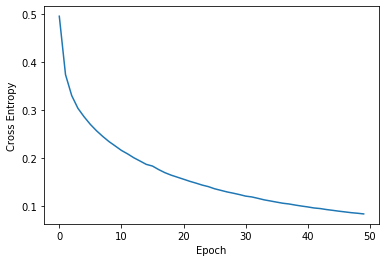

In [8]:
# Plotting cost versus epoch
plt.plot(range(len(epoch_cost)), epoch_cost)
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.show()

In [10]:
# Computing accuracy against train + test datasets
def compute_accuracy(model, data_loader):
  correct_prediction = 0
  num_examples = 0

  with torch.no_grad():
    for features, targets in data_loader:
      
      features = features.view(-1, 28*28).to(DEVICE)
      targets = targets.to(DEVICE)

      logits, probas = model.forward(features)
      predicted_labels = torch.argmax(probas, 1)

      num_examples += targets.size(0)
      correct_prediction += (predicted_labels == targets).sum()
    return float(correct_prediction)/num_examples * 100

print('Training accuracy: %.2f' % compute_accuracy(model, train_loader))
print('Test accuracy: %.2f' % compute_accuracy(model, test_loader))

Training accuracy: 97.74
Test accuracy: 96.84
